In [1]:
!pip install seaborn
!pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression, ARDRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import tensorflow as tf
import keras
from keras import backend as K

# Загрузка датасета

Прочитаем датасет

In [3]:
X = pd.read_csv("./X.csv")
Y = pd.read_csv("./y.csv")

Разделим на тестовую и валидационную выборку

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, shuffle=True, random_state=42)

In [5]:
X_train.head()

,engine_id,aircraft_id,flight_datetime,flight_phase,engine_position,n1_modifier,number_blades,engine_family,engine_type,manufacturer,...,ZT1A,ZVIAS,ZWBP1,ZWBP1_8E,ZWBP2,ZWBP2_8E,ZXM,IBE,IBP,IAIE
53491,f0265f39ceb31d05b5ba935c2682b3281c13efa6f38b84...,557fe9494c53f97663a1dc92ae8a1d4b4a95e4c3fe76c0...,2022-07-27 01:39:50,CRUISE,2,3.0,36.0,CFM56-5B,CFM56-5B3,CFM INTERNATIONAL,...,-13.900000,NaN,1.124356,NaN,1.366864,NaN,0.7750,1.0,NaN,NaN
59691,8c97da4bc8feab053617a7323564a5bd3ea7a4c12d2ec9...,a3ee6d52224435498a06cbd1b6fbddb98d4c0ae15f52ad...,2022-07-11 22:09:36,TAKEOFF,1,0.0,28.0,CF34-8E,CF34-8E5,GE AIRCRAFT ENGINES,...,31.799999,163.800003,NaN,45.335899,NaN,47.421799,0.2490,1.0,1.0,0.0
70768,2de859ab7ad97150d56effc86e5f9cc5349f265903f297...,939c9231d25e2e31a7fef4ee60c025fb8d4bf7a15a904d...,2022-02-25 21:22:23,CRUISE,2,0.0,36.0,CFM56-5B,CFM56-5B3,CFM INTERNATIONAL,...,-31.000000,NaN,1.146402,NaN,1.146402,NaN,0.7740,1.0,NaN,NaN
71418,315710d12224c70ccae5380b0f979c31516b24e9b2845b...,608880d5e86057641cecff59561c42a6b267accd48f39c...,2022-05-06 12:40:59,TAKEOFF,1,1.0,24.0,CFM56-7,CFM56-7B26,CFM INTERNATIONAL,...,12.750000,NaN,NaN,NaN,NaN,NaN,0.3492,1.0,1.0,0.0
31719,0bdbb6fafb9f58179ffce03597371ca6084dcb1f4dfe44...,8fd689ed3c47d7dea87039788ac47a91e691d6d0339e20...,2022-03-15 10:40:11,CRUISE,1,0.0,36.0,CFM56-5B,CFM56-5B3,CFM INTERNATIONAL,...,-32.799999,NaN,1.146402,NaN,1.146402,NaN,0.7790,1.0,NaN,NaN


In [6]:
y_train.head()

,flight_datetime,flight_phase,engine_id,BRAT,DEGT,DELFN,DELN1,DELVSV,DPOIL,EGTC,...,SLOATL_D,VSVNOM,WBE,WBI,WFMP,ZPCN25_D,ZT49_D,ZTLA_D,ZTNAC_D,ZWF36_D
53491,2022-07-27 01:39:50,CRUISE,f0265f39ceb31d05b5ba935c2682b3281c13efa6f38b84...,1.035500,-15.908203,NaN,NaN,1.9,-22.962318,695.408203,...,NaN,0.0,1.36686,0.035500,3306.42651,0.150002,-6.250000,NaN,6.5,34.171631
59691,2022-07-11 22:09:36,TAKEOFF,8c97da4bc8feab053617a7323564a5bd3ea7a4c12d2ec9...,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,4.413731,NaN,NaN,NaN,NaN,-0.273445,-15.687500,NaN,NaN,0.000000
70768,2022-02-25 21:22:23,CRUISE,2de859ab7ad97150d56effc86e5f9cc5349f265903f297...,0.868485,-13.558105,NaN,NaN,2.6,-20.914490,609.658081,...,NaN,0.0,1.14640,-0.131515,3079.24902,-0.049995,-4.400024,NaN,-8.0,-6.613770
71418,2022-05-06 12:40:59,TAKEOFF,315710d12224c70ccae5380b0f979c31516b24e9b2845b...,1.000000,NaN,15.013059,5.515953,NaN,NaN,NaN,...,-0.861954,NaN,NaN,NaN,NaN,-0.125000,2.000000,NaN,NaN,NaN
31719,2022-03-15 10:40:11,CRUISE,0bdbb6fafb9f58179ffce03597371ca6084dcb1f4dfe44...,0.868485,-17.825561,NaN,NaN,2.0,-20.624638,636.925537,...,NaN,0.0,1.14640,-0.131515,3288.47119,-0.050003,-3.650024,NaN,-29.0,-56.217773


# Анализ данных

## Подготовим вспомогательные функции

Выбросы - это те точки данных, которые значительно отличаются от остальной части набора данных.
Часто это аномальные наблюдения, которые искажают распределение данных и возникают из-за непоследовательного ввода данных или ошибочных наблюдений.
Чтобы гарантировать, что обученная модель хорошо подходит к допустимому диапазону тестовых входных данных, важно обнаруживать и удалять выбросы.

С помощью следующей функции мы сможем обнаружить выбросы.

In [7]:
def boxPlot(X, columns=None):
    if columns is None:
        columns = X.columns
    for i in columns:
        sns.boxplot(x=X[i])
        plt.show()
    pass

## Приступим к анализу

Посмотрим на размер датасета

In [8]:
X_train.shape

(64043, 53)

Посмотрим на количество пустых ячеек во входных данных

In [9]:
X_train.isna().sum()

engine_id              0
aircraft_id            0
flight_datetime        0
flight_phase           0
engine_position        0
n1_modifier            0
number_blades          0
engine_family          0
engine_type            0
manufacturer           0
ZHPTAC             47970
ZLPTAC             47970
ZPCN12                 0
ZPCN25                 0
ZPHSF              46122
ZPHSR              46122
ZPN12R             39413
ZPOIL              13268
ZPS3               39414
ZT1AB              39413
ZT3                39414
ZT49                   0
ZTAMB              39412
ZTLA               39412
ZTNAC              47970
ZTOIL              13268
ZVB1F                  6
ZVB1R              34729
ZVB2F              34750
ZVB2R              10119
ZVSV               23341
ZWF36              13247
IHPSOV             39412
aircraft_family        0
aircraft_type          0
aircraft_grp           0
ac_manufacturer        0
AGW                24631
CAS                34723
IAI                38324


Посмотрим на количество пустых ячеек в выходных данных

In [10]:
y_train.isna().sum()

flight_datetime        0
flight_phase           0
engine_id              0
BRAT                 102
DEGT               26140
DELFN              50855
DELN1              50855
DELVSV             48084
DPOIL              38225
EGTC               26140
EGTHDM             14549
EGTHDM_D           38623
GEGTMC             38291
GN2MC              38291
GPCN25             26140
GWFM               26140
PCN12                394
PCN12I             12809
PCN1AR             50819
PCN1BR             50796
PCN1K                537
PCN2C              26140
SLOATL             14549
SLOATL_D           38623
VSVNOM             48084
WBE                46096
WBI                25720
WFMP               26140
ZPCN25_D             177
ZT49_D               177
ZTLA_D             51885
ZTNAC_D            47978
ZWF36_D            13338
dtype: int64

Выделим поля с пропусками

In [11]:
nullCols = ['ZHPTAC', 'ZLPTAC', 'ZPHSF', 'ZPHSR', 'ZPN12R', 'ZPOIL', 'ZPS3', 'ZT1AB', 'ZT3',
       'ZTAMB', 'ZTLA', 'ZTNAC', 'ZTOIL', 'ZVB1F', 'ZVB1R', 'ZVB2F', 'ZVB2R',
       'ZVSV', 'ZWF36', 'IHPSOV', 'AGW', 'CAS', 'IAI', 'IVS12', 'SAT',
       'ZVIAS', 'ZWBP1', 'ZWBP1_8E', 'ZWBP2', 'ZWBP2_8E',
       'IBP', 'IAIE']

Определим категориальные признаки

In [12]:
catCols = ['n1_modifier', 'flight_phase', 'engine_family', 'engine_type', 'manufacturer', 'aircraft_family', 'aircraft_type', 'aircraft_grp', 'ac_manufacturer']

Подгтовим данные к дальнейшему анализу

In [13]:
def correct_X(X: pd.DataFrame):
    newX = X.drop(columns=["engine_id", "aircraft_id", "flight_datetime"])
    for nullCol in nullCols:
        X.loc[X[X[nullCol].isna()].index, nullCol] = X[nullCol].mean()
    # corrected params
    theta = newX['ZT1A'] / 288.15
    P = newX['ZALT'] / 1013.25
    theta[theta <= 0] = 0.001
    P[P == 0] = 10
    newX['EGTK'] = (newX['ZT49'] + 273.15) / theta
    newX['FFK'] = newX['ZWF36'] / (np.sqrt(theta) * P)
    newX['N2K'] = newX['ZPCN25'] / np.sqrt(theta)
    newX['N1K'] = newX['ZPCN12'] / np.sqrt(theta)
    newX = newX.drop(columns=catCols[1:])
    newX = pd.get_dummies(newX, columns=[catCols[0]])
    return newX

In [14]:
def correct_Y(Y: pd.DataFrame):
    categorialFeatures = list(Y.columns[Y.dtypes == object])
    newY = Y.drop(columns=categorialFeatures)
    return newY

In [15]:
X_train = correct_X(X_train)
y_train = correct_Y(y_train)
X_test = correct_X(X_test)
y_test = correct_Y(y_test)

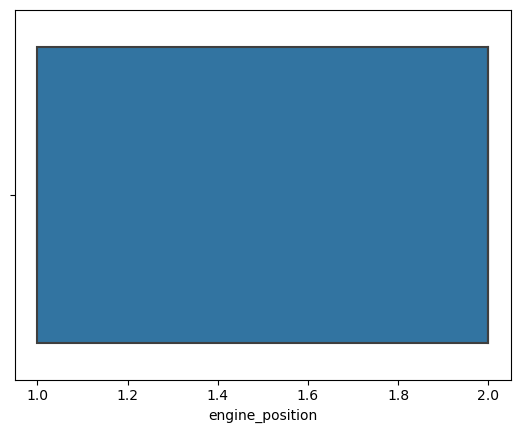

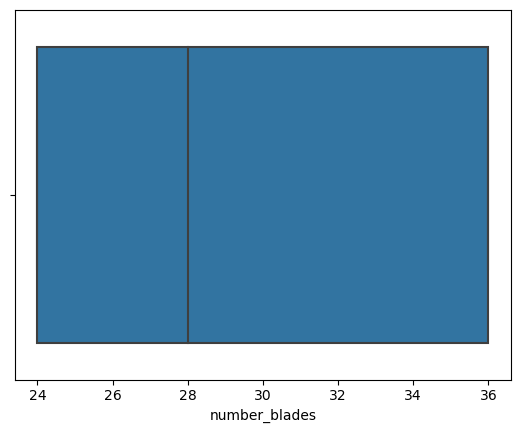

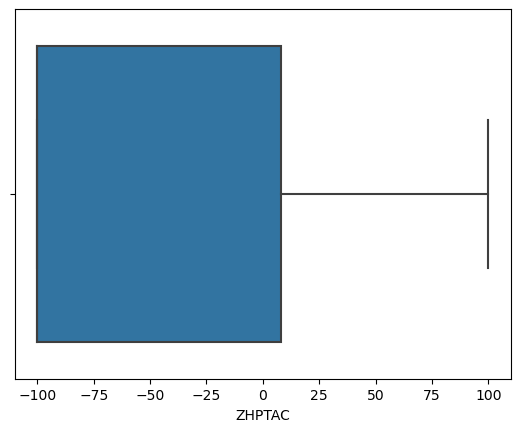

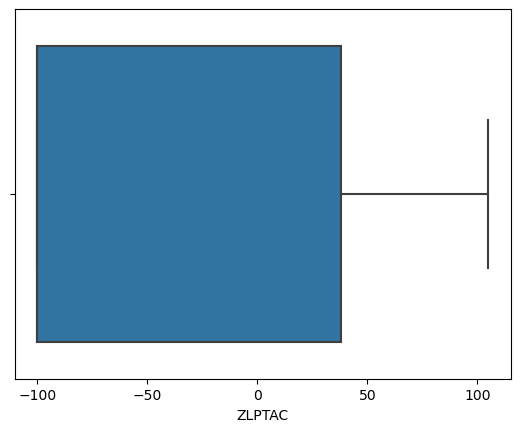

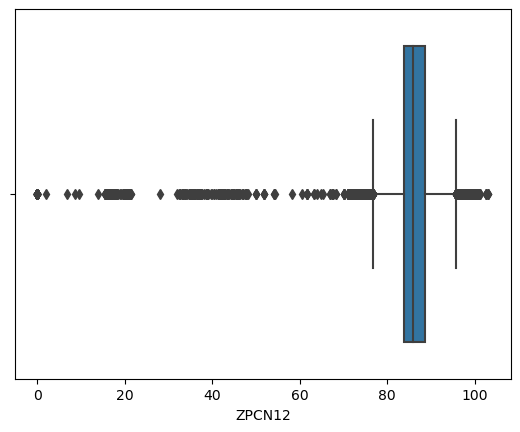

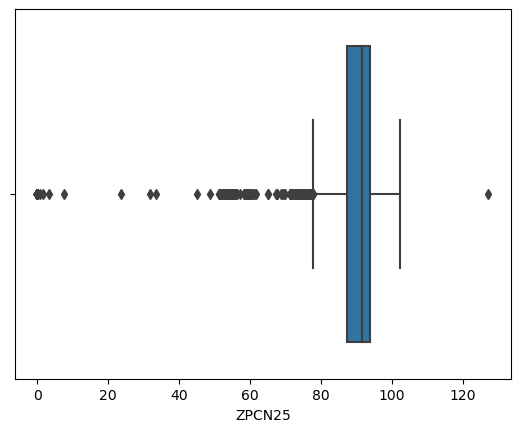

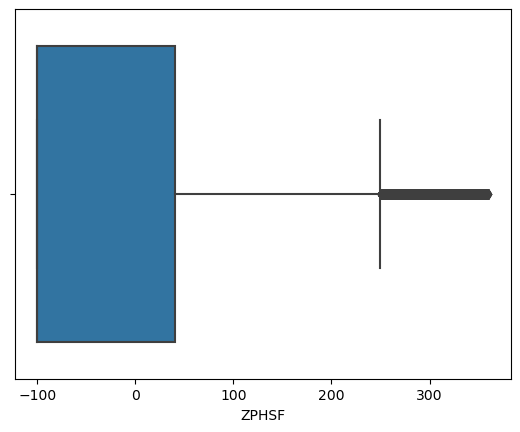

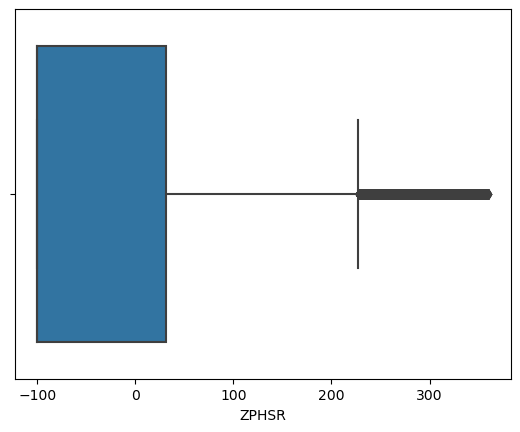

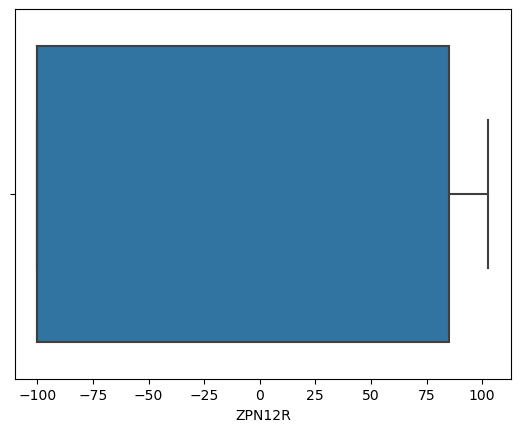

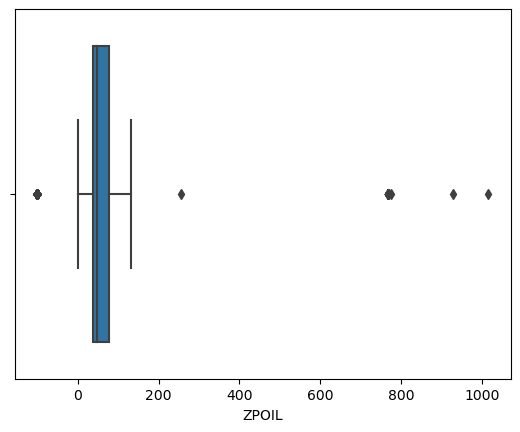

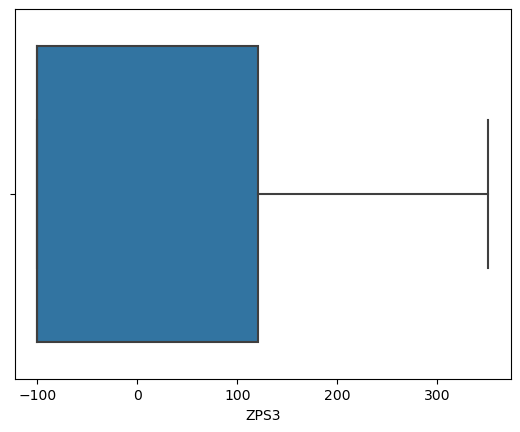

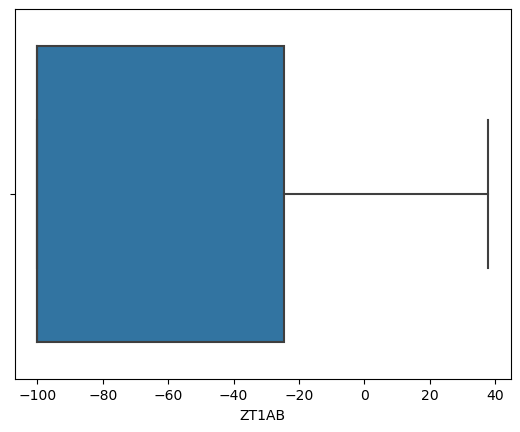

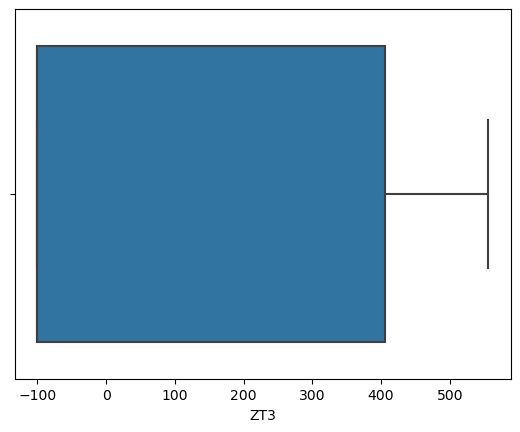

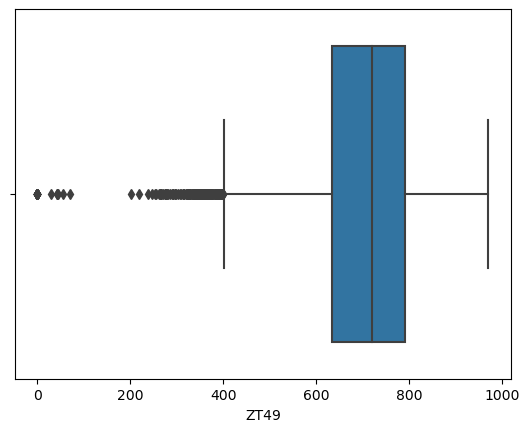

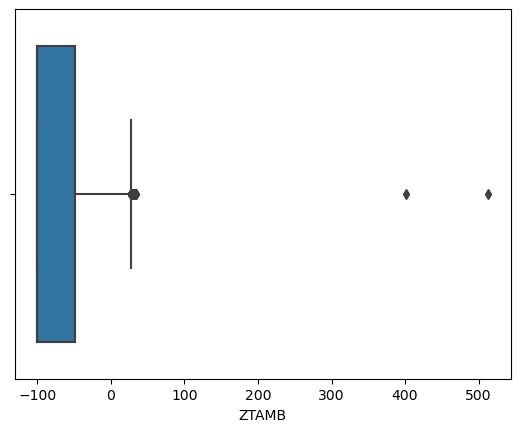

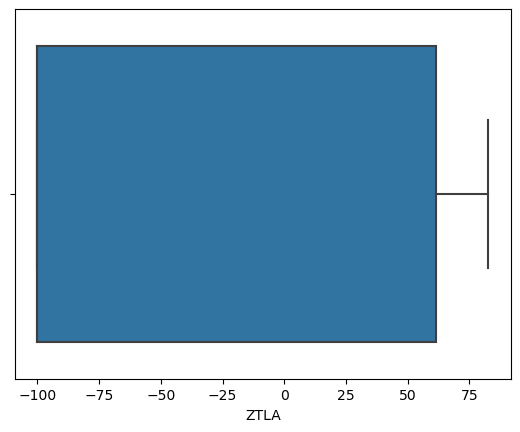

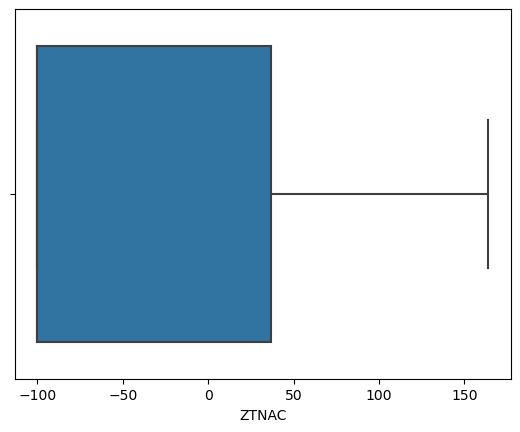

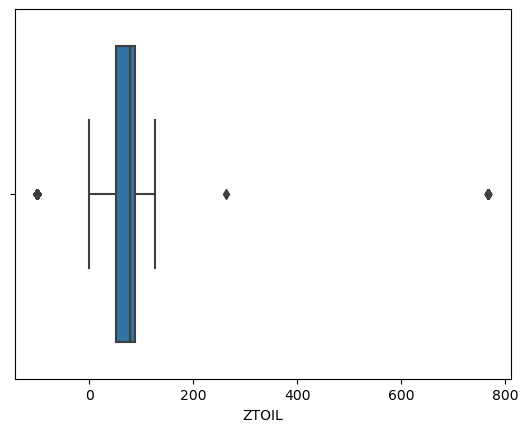

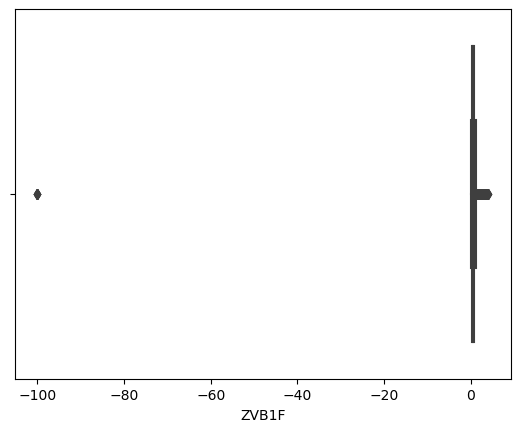

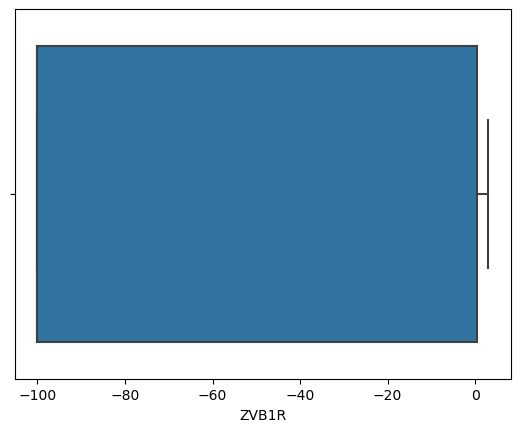

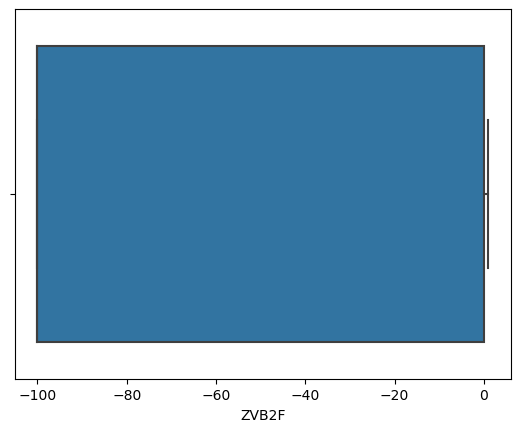

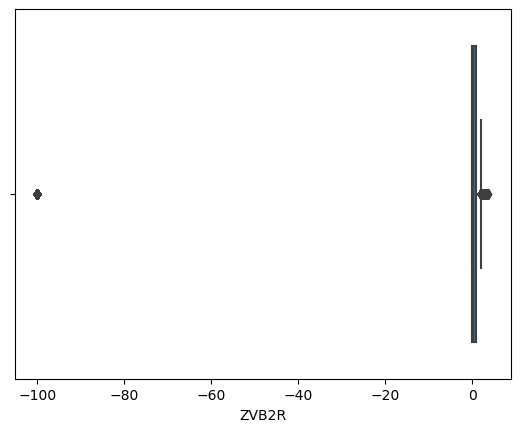

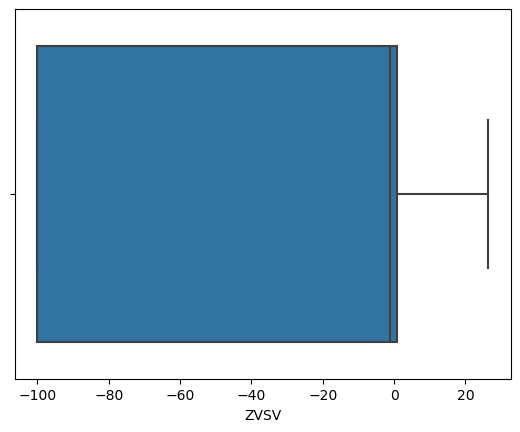

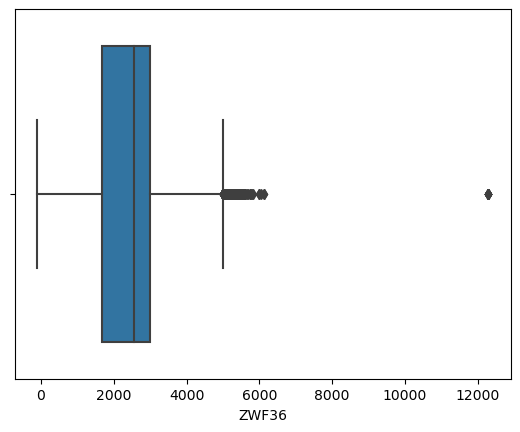

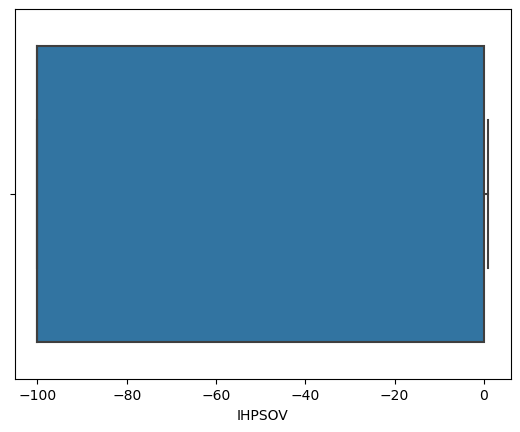

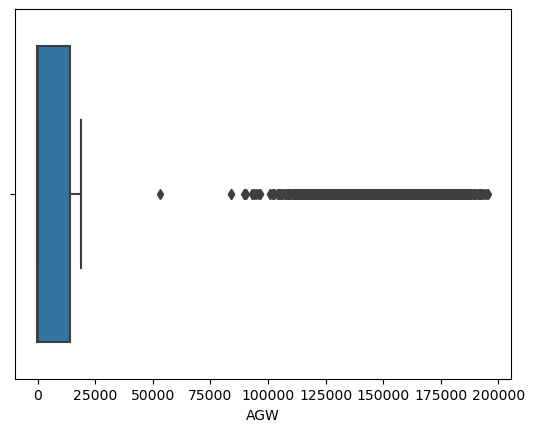

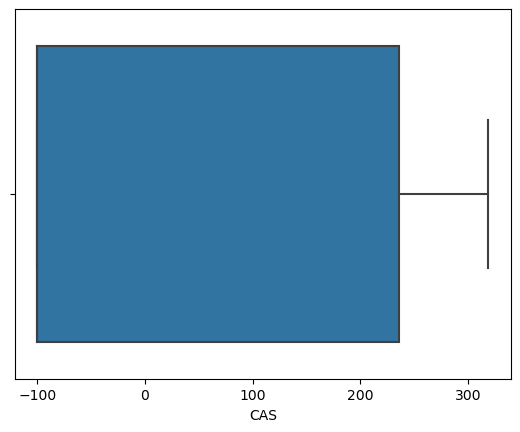

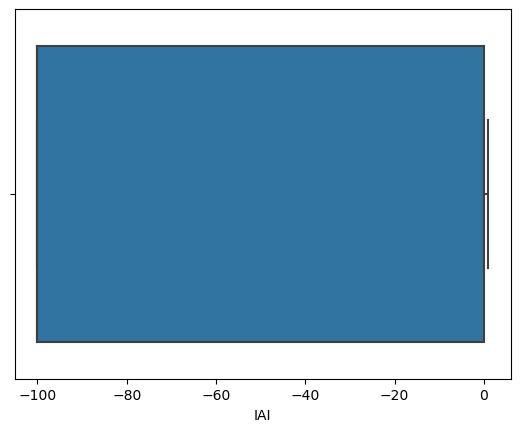

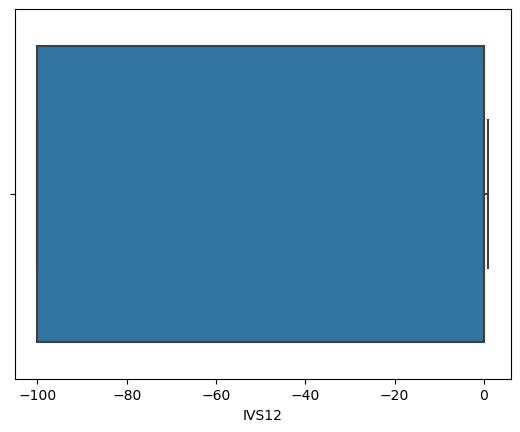

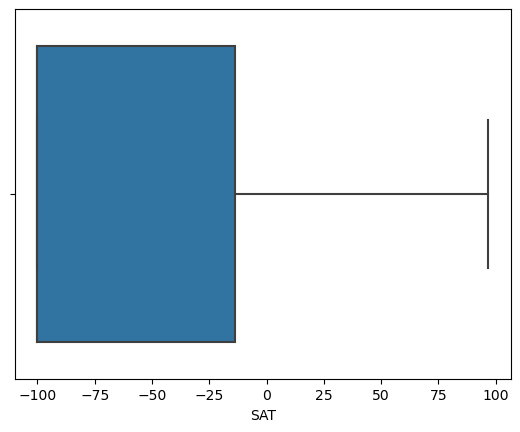

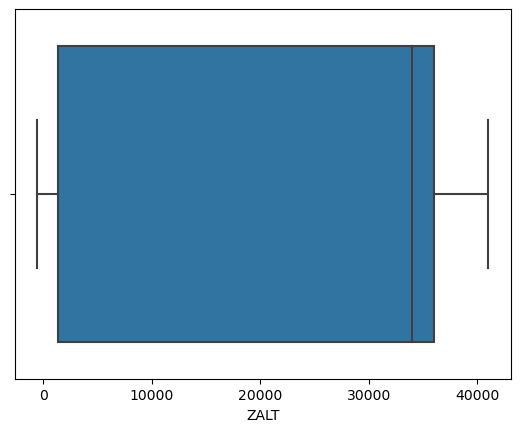

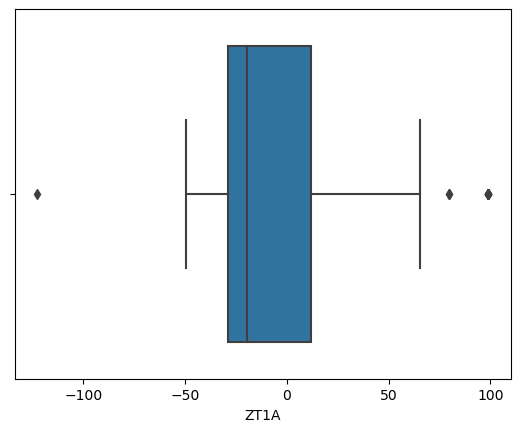

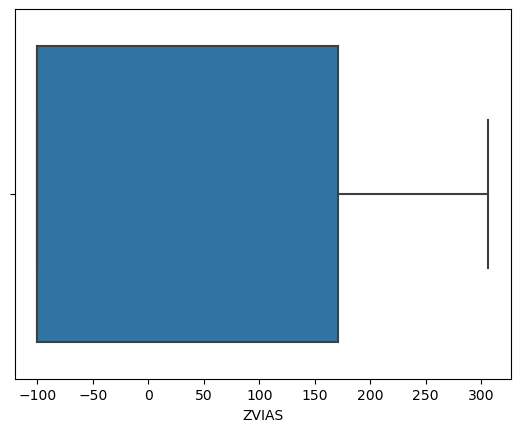

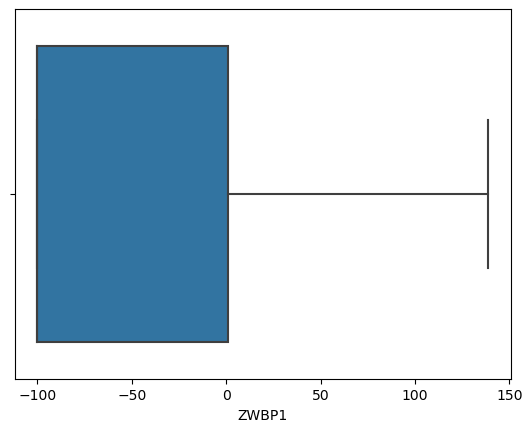

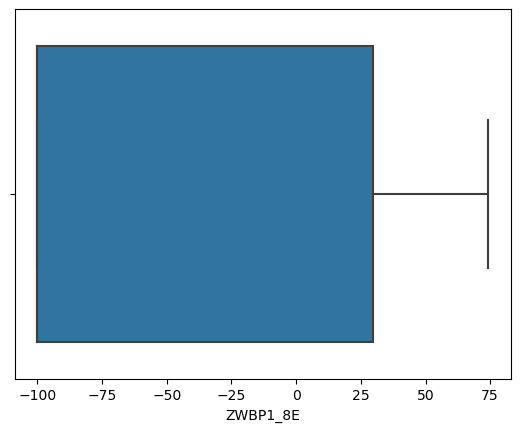

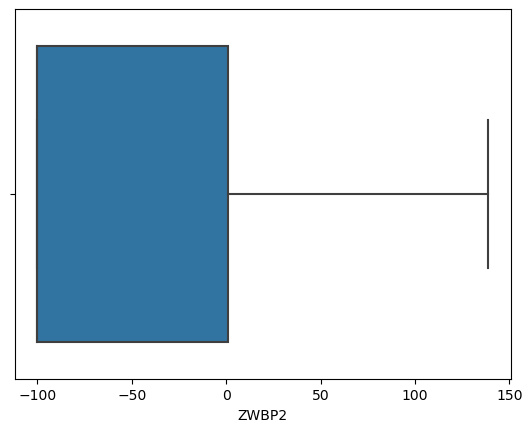

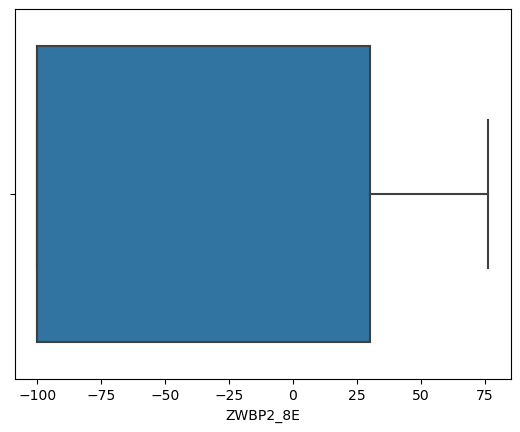

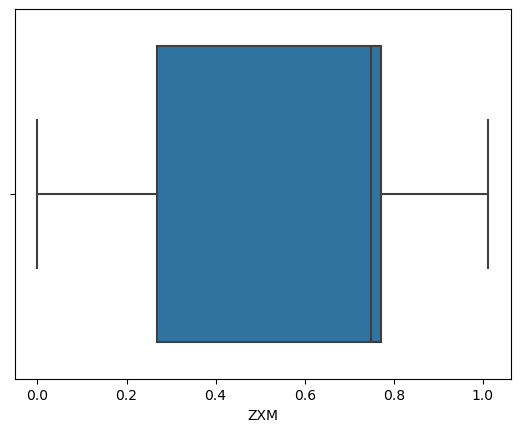

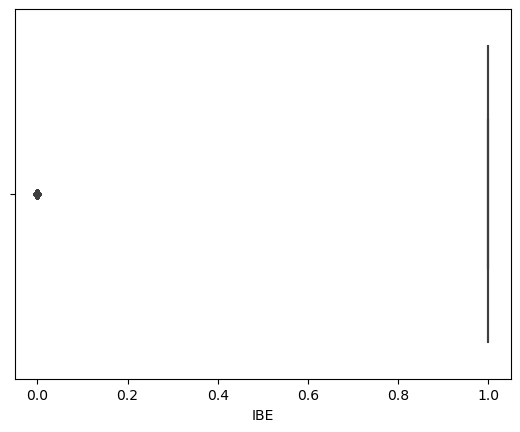

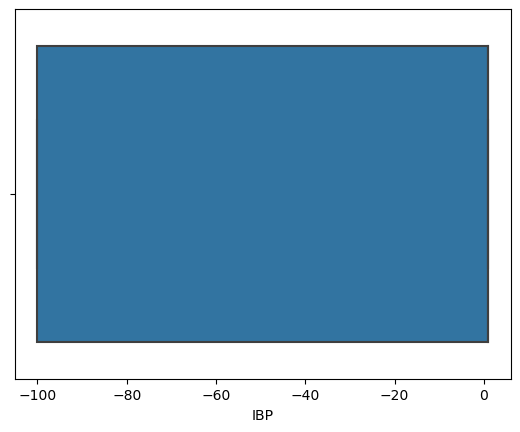

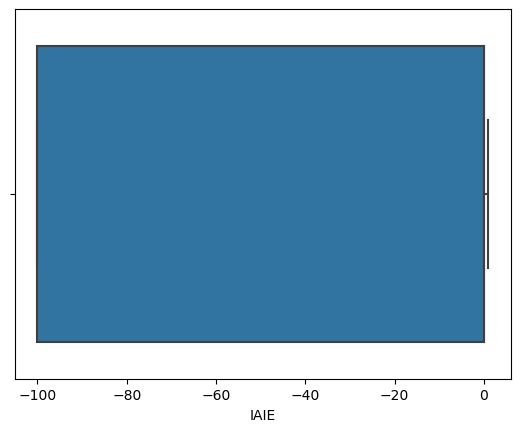

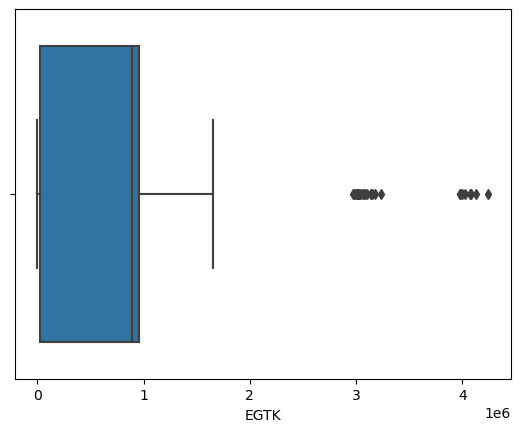

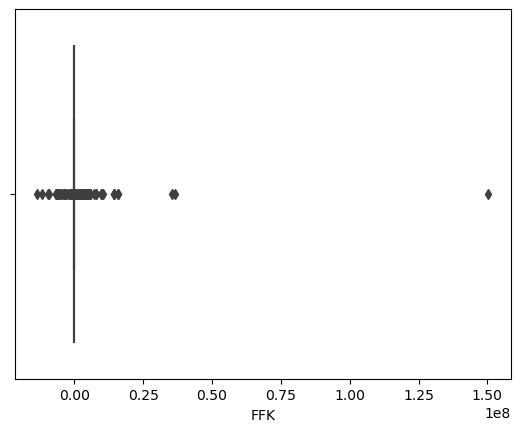

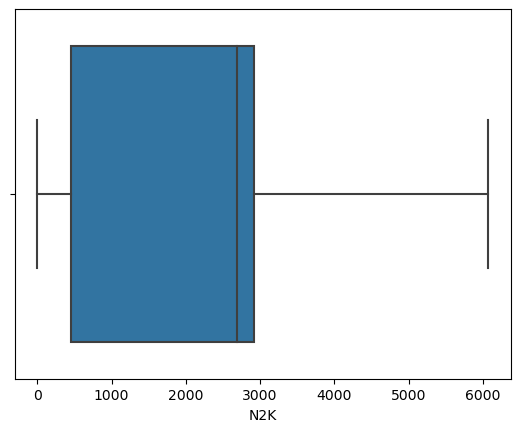

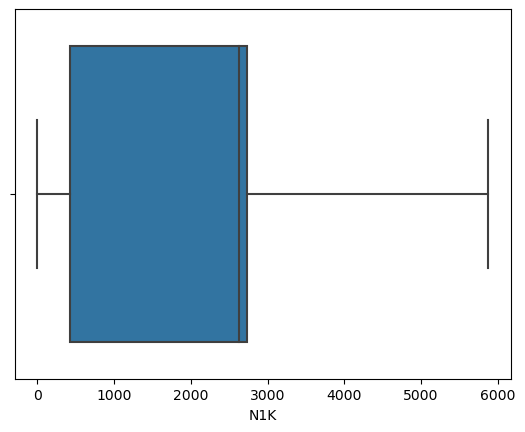

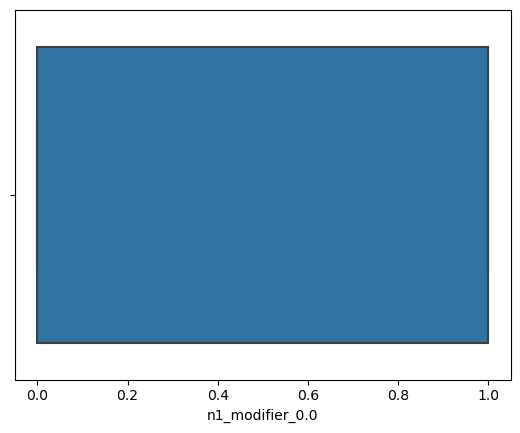

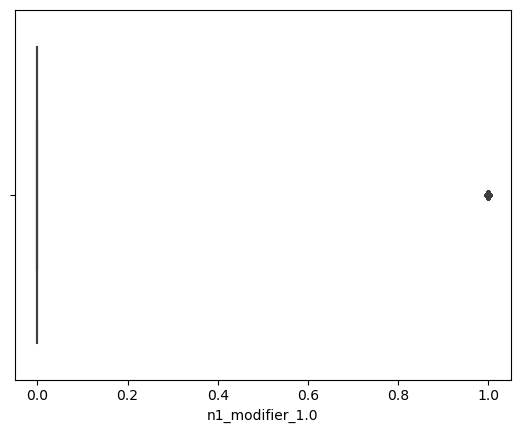

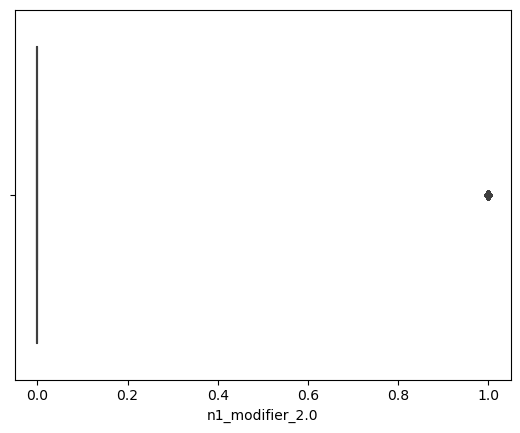

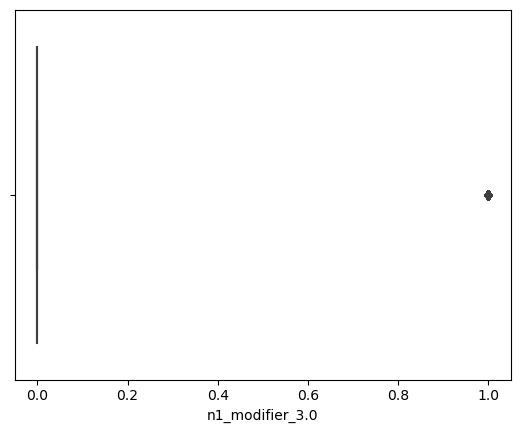

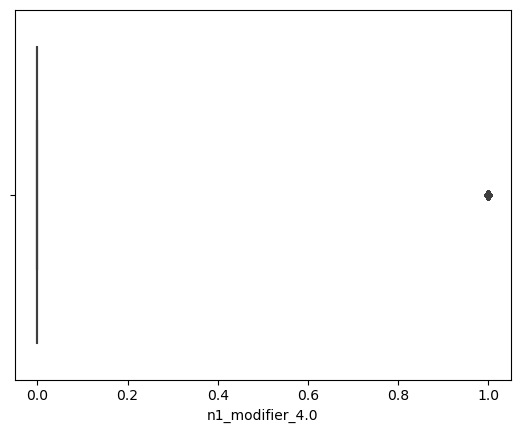

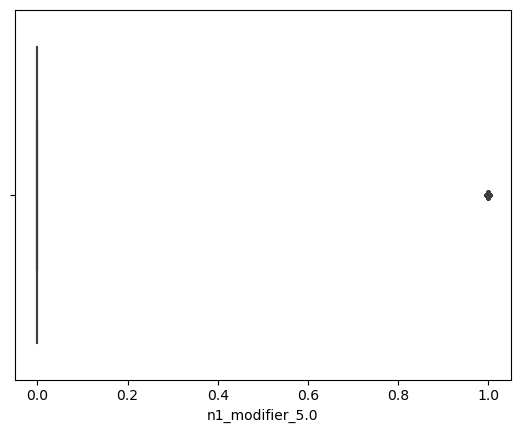

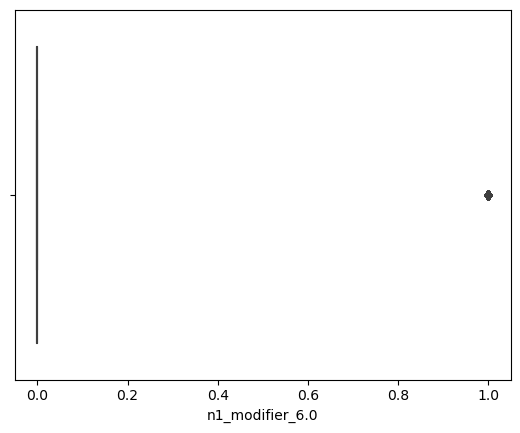

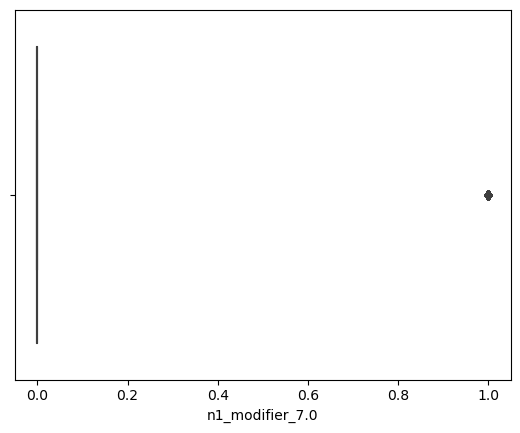

In [16]:
boxPlot(X_train)

In [17]:
X_train.isna().sum()

engine_position    0
number_blades      0
ZHPTAC             0
ZLPTAC             0
ZPCN12             0
ZPCN25             0
ZPHSF              0
ZPHSR              0
ZPN12R             0
ZPOIL              0
ZPS3               0
ZT1AB              0
ZT3                0
ZT49               0
ZTAMB              0
ZTLA               0
ZTNAC              0
ZTOIL              0
ZVB1F              0
ZVB1R              0
ZVB2F              0
ZVB2R              0
ZVSV               0
ZWF36              0
IHPSOV             0
AGW                0
CAS                0
IAI                0
IVS12              0
SAT                0
ZALT               0
ZT1A               0
ZVIAS              0
ZWBP1              0
ZWBP1_8E           0
ZWBP2              0
ZWBP2_8E           0
ZXM                0
IBE                0
IBP                0
IAIE               0
EGTK               0
FFK                0
N2K                0
N1K                0
n1_modifier_0.0    0
n1_modifier_1.0    0
n1_modifier_2

Отлично, датасет готов

In [18]:
class Trainer:
    def __init__(self, targets, models):
        # StandardScaler() - cтандартизация – это метод масштабирования, при котором данные не масштабируются путем
        # преобразования статистического распределения данных в следующий формат:
        # среднее – 0 (ноль); стандартное отклонение – 1.
        self.scaler = StandardScaler()
        self.targets = targets
        self.models = models
        self.predict_data = {}

    def fit(self, X, Y, X_test, y_test):
        """
        !Осущесвляет подгонку семейства моделей под обучающую выборку
        !сохраняет в параметр fit_data словарь обученных моделей для каждого таргета
        """
        # шкалируем
        X_scaler = self.scaler.fit_transform(X)
        self.fit_data = {
            target:
            {name_model:
                 self.models[name_model].fit(X_scaler, Y[target]) if 'neuro' not in name_model
             else
                 self.models[name_model].fit(X_scaler, Y[target], validation_batch_size=50,
                                         validation_data=(X_test, y_test),
                                         epochs=100, verbose=0, callbacks=my_callbacks)
             for name_model in self.models
             } for target in self.targets
        }


    def bestMetric(self, target):
        return min(self.errors[target], key=self.errors[target].get)

    def countModelTargetMetric(self, Y):
        """
        !Рассчитывает метрики для каждой модели из семейства для каждого предсказываемого таргета.
        !Конкретная метрика задаётся в параметрах. В работе использовалась MSE
        !Также формирует статистику для каждого таргета и модели; статистику для лучшей модели
        !Возвращает metric - данные о лучшей модели и значении метрики
        """
        e = mean_squared_error

        self.errors, self.metric, self.best_model = {}, {}, {}
        self.metric = {}

        for target in self.targets:
            self.errors[target] = {name_model: e(Y[target], value, squared=False) for name_model, value in self.predict_data[target].items()}
            best_model_name = self.bestMetric(target)
            self.metric[target] = {'best_model': best_model_name,
                                 'best_metric': self.errors[target][best_model_name]}
            self.best_model[target] = self.models[best_model_name]
        return pd.DataFrame(self.metric)

    def predictModels(self, X):
        """
        !Расчет предсказанных значений на X_test для каждой из модели для каждого таргета
        """
        X_scaler = self.scaler.transform(X)
        self.predict_data = {target:
                             {name_model:
                              self.models[name_model].predict(X_scaler) for name_model in self.models
                              } for target in self.targets
                             }
        return self.predict_data

    def predict(self, X):
        """
        !Рассчитывает и возвращает предикт на лучшей для данного таргета модели
        """
        X_scaler = self.scaler.transform(X)
        predict = pd.DataFrame([])
        for target in self.targets:
            best_model_name = self.bestMetric(target)
            predict[target] = self.best_model[target].predict(X_scaler).flatten()
        return predict

In [19]:
def learningRateControl(epoch, learningRate):
    """
    !Управление learning_rate во время обучения.
    !Для новоого таргета learningRate сбрасывается на начальное, по мере обучения и роста эпох уменьшается
    """
    if epoch < 2:
        learningRate = 0.001
    else:
        if epoch % 10 == 0:
            learningRate = learningRate / 2
    return learningRate

optimizer = keras.optimizers.Adam(0.001, decay=1e-6)

  # Прописываем условия для ранней остановки и управление LR
my_callbacks = [
    #Предполагая, что цель обучения состоит в том, чтобы свести к минимуму потери.
    # Тренировочный цикл будет проверять в конце каждой эпохи: если потери больше не уменьшаются, помечается True, и обучение завершается
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4),
    # ModelCheckpoint(monitor='val_loss', save_best_only=True, save_weights_only=True),
    keras.callbacks.LearningRateScheduler(learningRateControl, verbose=0)
]

In [20]:
model1 = keras.models.Sequential() #группируем слои модели
# Dense реализует операцию: output = activation(dot(input, kernel) + bias) , где activation — это поэлементная
# функция активации, переданная в качестве аргумента activation kernel
model1.add(keras.layers.Dense(50, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model1.add(keras.layers.Dense(20, kernel_initializer='normal', activation='relu'))
model1.add(keras.layers.Dense(1, kernel_initializer='normal'))
# Compile model
model1.compile(loss='mean_squared_error', optimizer=optimizer)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                2700      
                                                                 
 dense_1 (Dense)             (None, 20)                1020      
                                                                 
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 3,741
Trainable params: 3,741
Non-trainable params: 0
_________________________________________________________________


In [21]:
model2 = keras.models.Sequential()
model2.add(keras.layers.Dense(20, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model2.add(keras.layers.Dense(10, kernel_initializer='normal', activation='relu'))
model2.add(keras.layers.Dense(1, kernel_initializer='normal'))
# Compile model
model2.compile(loss='mean_squared_error', optimizer=optimizer)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 20)                1080      
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________


In [22]:
model3 = keras.models.Sequential()
model3.add(keras.layers.Dense(100, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model3.add(keras.layers.Dense(50, kernel_initializer='normal', activation='relu'))
model3.add(keras.layers.Dense(1, kernel_initializer='normal'))
# Compile model
model3.compile(loss='mean_squared_error', optimizer=optimizer)
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               5400      
                                                                 
 dense_7 (Dense)             (None, 50)                5050      
                                                                 
 dense_8 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,501
Trainable params: 10,501
Non-trainable params: 0
_________________________________________________________________


In [23]:
model4 = keras.models.Sequential()
model4.add(keras.layers.Dense(60, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model4.add(keras.layers.Dense(30, kernel_initializer='normal', activation='relu'))
model4.add(keras.layers.Dense(10, kernel_initializer='normal', activation='relu'))
model4.add(keras.layers.Dense(1, kernel_initializer='normal'))
# Compile model
model4.compile(loss='mean_squared_error', optimizer=optimizer)
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 60)                3240      
                                                                 
 dense_10 (Dense)            (None, 30)                1830      
                                                                 
 dense_11 (Dense)            (None, 10)                310       
                                                                 
 dense_12 (Dense)            (None, 1)                 11        
                                                                 
Total params: 5,391
Trainable params: 5,391
Non-trainable params: 0
_________________________________________________________________


In [24]:
model5 = keras.models.Sequential()
model5.add(keras.layers.Dense(50, input_dim=X_train.shape[1], kernel_initializer='normal', activation='tanh'))
model5.add(keras.layers.Dense(20, kernel_initializer='normal', activation='tanh'))
model5.add(keras.layers.Dense(1, kernel_initializer='normal'))
# Compile model
model5.compile(loss='mean_squared_error', optimizer=optimizer)
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 50)                2700      
                                                                 
 dense_14 (Dense)            (None, 20)                1020      
                                                                 
 dense_15 (Dense)            (None, 1)                 21        
                                                                 
Total params: 3,741
Trainable params: 3,741
Non-trainable params: 0
_________________________________________________________________


In [25]:
model6 = keras.models.Sequential()
model6.add(keras.layers.Dense(20, input_dim=X_train.shape[1], kernel_initializer='normal', activation='tanh'))
model6.add(keras.layers.Dense(10, kernel_initializer='normal', activation='tanh'))
model6.add(keras.layers.Dense(1, kernel_initializer='normal'))
# Compile model
model6.compile(loss='mean_squared_error', optimizer=optimizer)
model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 20)                1080      
                                                                 
 dense_17 (Dense)            (None, 10)                210       
                                                                 
 dense_18 (Dense)            (None, 1)                 11        
                                                                 
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
_________________________________________________________________


In [26]:
model7 = keras.models.Sequential()
model7.add(keras.layers.Dense(100, input_dim=X_train.shape[1], kernel_initializer='normal', activation='tanh'))
model7.add(keras.layers.Dense(50, kernel_initializer='normal', activation='tanh'))
model7.add(keras.layers.Dense(1, kernel_initializer='normal'))
# Compile model
model7.compile(loss='mean_squared_error', optimizer=optimizer)
model7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 100)               5400      
                                                                 
 dense_20 (Dense)            (None, 50)                5050      
                                                                 
 dense_21 (Dense)            (None, 1)                 51        
                                                                 
Total params: 10,501
Trainable params: 10,501
Non-trainable params: 0
_________________________________________________________________


In [27]:
model8 = keras.models.Sequential()
model8.add(keras.layers.Dense(60, input_dim=X_train.shape[1], kernel_initializer='normal', activation='tanh'))
model8.add(keras.layers.Dense(30, kernel_initializer='normal', activation='tanh'))
model8.add(keras.layers.Dense(10, kernel_initializer='normal', activation='tanh'))
model8.add(keras.layers.Dense(1, kernel_initializer='normal'))
# Compile model
model8.compile(loss='mean_squared_error', optimizer=optimizer)
model8.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 60)                3240      
                                                                 
 dense_23 (Dense)            (None, 30)                1830      
                                                                 
 dense_24 (Dense)            (None, 10)                310       
                                                                 
 dense_25 (Dense)            (None, 1)                 11        
                                                                 
Total params: 5,391
Trainable params: 5,391
Non-trainable params: 0
_________________________________________________________________


In [28]:
targets = y_train.columns

# Словарь с моделями, на которых обучаемся предсказывать каждый из таргетов
models = {
    'lasso': Lasso(random_state=66),
    'ridge': Ridge(random_state=66),
    'linear': LinearRegression(),
    'ARD': ARDRegression(),
    'random_tree': RandomForestRegressor(verbose=0),
    'catboost': CatBoostRegressor(iterations=100, verbose=0, random_state=66),
    'XGB': XGBRegressor(random_state=66),
    'neuro1': model1,
    'neuro2': model2,
    'neuro3': model3,
    'neuro4': model4,  
    'neuro5': model5,
    'neuro6': model6,
    'neuro7': model7,
    'neuro8': model8  
}

In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64043 entries, 53491 to 15795
Data columns (total 53 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   engine_position  64043 non-null  int64  
 1   number_blades    64043 non-null  float64
 2   ZHPTAC           64043 non-null  float64
 3   ZLPTAC           64043 non-null  float64
 4   ZPCN12           64043 non-null  float64
 5   ZPCN25           64043 non-null  float64
 6   ZPHSF            64043 non-null  float64
 7   ZPHSR            64043 non-null  float64
 8   ZPN12R           64043 non-null  float64
 9   ZPOIL            64043 non-null  float64
 10  ZPS3             64043 non-null  float64
 11  ZT1AB            64043 non-null  float64
 12  ZT3              64043 non-null  float64
 13  ZT49             64043 non-null  float64
 14  ZTAMB            64043 non-null  float64
 15  ZTLA             64043 non-null  float64
 16  ZTNAC            64043 non-null  float64
 17  ZTOIL   

In [30]:
predict, er = pd.DataFrame([]), pd.DataFrame([])

# Перебираем каждый таргет, стратегия обучения: обучаемся только на тех значениях таргета, где нет пропусков.
# Для этого формируется X_train, y_train для якаждого таргета отдельно
# и на них производится подгонка моделей
for target in tqdm(targets):
    if target == 'VSVNOM':
        predict[target] = 0
        continue
    
  # Обучаем только на непустых данных в таргете
    y_train_ = y_train[y_train[target].notna()]
    X_train_ = X_train[y_train[target].notna()]

    y_test_ = y_test[y_test[target].notna()]
    X_test_ = X_test[y_test[target].notna()]

    # Обучение семейства моделей
    mt = Trainer(targets=[target], models=models)
    mt.fit(X_train_, y_train_, X_test_, y_test_)

    # Вычисление метрики для каждой модели
    predicts_models = mt.predictModels(X_test_)
    # Лучшая модель и лучшая метрика
    er[target] = mt.countModelTargetMetric(y_test_)

    # На лучшей модели предсказываем тестовую выборку
    predict[target] = mt.predict(X_test)

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]

985/985 [==============================] - 0s 425us/step


  3%|██▊                                                                                | 1/30 [01:23<40:28, 83.75s/it]

986/986 [==============================] - 0s 424us/step


  7%|█████▌                                                                             | 2/30 [02:47<39:07, 83.85s/it]

207/207 [==============================] - 0s 417us/step


 10%|████████▎                                                                          | 3/30 [03:13<25:49, 57.37s/it]

207/207 [==============================] - 0s 417us/step


 13%|███████████                                                                        | 4/30 [03:39<19:27, 44.91s/it]

247/247 [==============================] - 0s 398us/step


 17%|█████████████▊                                                                     | 5/30 [03:59<14:57, 35.90s/it]

397/397 [==============================] - 0s 422us/step


 20%|████████████████▌                                                                  | 6/30 [04:37<14:43, 36.83s/it]

582/582 [==============================] - 0s 410us/step


 23%|███████████████████▎                                                               | 7/30 [05:57<19:27, 50.78s/it]

762/762 [==============================] - 0s 414us/step


 27%|██████████████████████▏                                                            | 8/30 [07:45<25:16, 68.94s/it]

393/393 [==============================] - 0s 408us/step


 30%|████████████████████████▉                                                          | 9/30 [08:53<24:06, 68.88s/it]

396/396 [==============================] - 0s 395us/step


 33%|███████████████████████████▎                                                      | 10/30 [09:45<21:11, 63.60s/it]

396/396 [==============================] - 0s 408us/step


 37%|██████████████████████████████                                                    | 11/30 [10:36<18:54, 59.69s/it]

582/582 [==============================] - 0s 444us/step


 40%|████████████████████████████████▊                                                 | 12/30 [12:01<20:11, 67.33s/it]

986/986 [==============================] - 0s 402us/step


 43%|███████████████████████████████████▌                                              | 13/30 [13:25<20:29, 72.33s/it]

980/980 [==============================] - 0s 425us/step


 47%|██████████████████████████████████████▎                                           | 14/30 [15:37<24:08, 90.54s/it]

791/791 [==============================] - 0s 459us/step


 50%|█████████████████████████████████████████                                         | 15/30 [17:06<22:27, 89.83s/it]

207/207 [==============================] - 0s 417us/step


 53%|███████████████████████████████████████████▋                                      | 16/30 [17:29<16:19, 69.96s/it]

208/208 [==============================] - 0s 396us/step


 57%|██████████████████████████████████████████████▍                                   | 17/30 [17:55<12:16, 56.63s/it]

978/978 [==============================] - 0s 407us/step


 60%|█████████████████████████████████████████████████▏                                | 18/30 [20:20<16:38, 83.21s/it]

582/582 [==============================] - 0s 413us/step


 63%|███████████████████████████████████████████████████▉                              | 19/30 [21:37<14:55, 81.42s/it]

762/762 [==============================] - 0s 406us/step


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [23:30<15:09, 90.91s/it]

393/393 [==============================] - 0s 385us/step


 70%|█████████████████████████████████████████████████████████▍                        | 21/30 [24:38<12:36, 84.05s/it]

277/277 [==============================] - 0s 424us/step


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [25:07<06:03, 51.90s/it]

589/589 [==============================] - 0s 440us/step


 80%|█████████████████████████████████████████████████████████████████▌                | 24/30 [25:56<05:06, 51.08s/it]C:\Users\anchi\miniconda3\envs\torch\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e+06, tolerance: 1.173e+06
  model = cd_fast.enet_coordinate_descent(


582/582 [==============================] - 0s 399us/step


 83%|████████████████████████████████████████████████████████████████████▎             | 25/30 [27:23<05:02, 60.54s/it]

983/983 [==============================] - 0s 402us/step


 87%|███████████████████████████████████████████████████████████████████████           | 26/30 [30:32<06:22, 95.53s/it]

983/983 [==============================] - 0s 425us/step


 90%|████████████████████████████████████████████████████████████████████████▉        | 27/30 [33:51<06:13, 124.46s/it]

186/186 [==============================] - 0s 427us/step


 93%|████████████████████████████████████████████████████████████████████████████▌     | 28/30 [34:27<03:18, 99.30s/it]

249/249 [==============================] - 0s 387us/step


 97%|███████████████████████████████████████████████████████████████████████████████▎  | 29/30 [35:01<01:20, 80.25s/it]C:\Users\anchi\miniconda3\envs\torch\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.364e+06, tolerance: 1.096e+05
  model = cd_fast.enet_coordinate_descent(


777/777 [==============================] - 0s 401us/step


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [37:48<00:00, 75.62s/it]


In [31]:
er

,BRAT,DEGT,DELFN,DELN1,DELVSV,DPOIL,EGTC,EGTHDM,EGTHDM_D,GEGTMC,...,SLOATL,SLOATL_D,WBE,WBI,WFMP,ZPCN25_D,ZT49_D,ZTLA_D,ZTNAC_D,ZWF36_D
best_metric,0.01808,2.458829,0.830275,0.420591,0.0,0.088686,2.155804,4.406377,4.698307,3.310201,...,1.560646,1.373987,0.188472,0.021149,20.677444,0.507528,7.255487,0.058014,2.334166,102.975009
best_model,catboost,neuro3,catboost,catboost,linear,catboost,XGB,XGB,random_tree,catboost,...,XGB,random_tree,linear,XGB,catboost,random_tree,random_tree,random_tree,random_tree,ARD


In [32]:
er.iloc[0]

BRAT           0.01808
DEGT          2.458829
DELFN         0.830275
DELN1         0.420591
DELVSV             0.0
DPOIL         0.088686
EGTC          2.155804
EGTHDM        4.406377
EGTHDM_D      4.698307
GEGTMC        3.310201
GN2MC         0.114446
GPCN25        0.099915
GWFM          0.539968
PCN12         0.079762
PCN12I        0.006332
PCN1AR        0.091827
PCN1BR        1.842012
PCN1K         0.119717
PCN2C         0.093909
SLOATL        1.560646
SLOATL_D      1.373987
WBE           0.188472
WBI           0.021149
WFMP         20.677444
ZPCN25_D      0.507528
ZT49_D        7.255487
ZTLA_D        0.058014
ZTNAC_D       2.334166
ZWF36_D     102.975009
Name: best_metric, dtype: object

In [33]:
er.iloc[1]

BRAT           catboost
DEGT             neuro3
DELFN          catboost
DELN1          catboost
DELVSV           linear
DPOIL          catboost
EGTC                XGB
EGTHDM              XGB
EGTHDM_D    random_tree
GEGTMC         catboost
GN2MC               XGB
GPCN25              XGB
GWFM             neuro7
PCN12       random_tree
PCN12I           linear
PCN1AR           linear
PCN1BR         catboost
PCN1K            linear
PCN2C               XGB
SLOATL              XGB
SLOATL_D    random_tree
WBE              linear
WBI                 XGB
WFMP           catboost
ZPCN25_D    random_tree
ZT49_D      random_tree
ZTLA_D      random_tree
ZTNAC_D     random_tree
ZWF36_D             ARD
Name: best_model, dtype: object

In [34]:
predict

,BRAT,DEGT,DELFN,DELN1,DELVSV,DPOIL,EGTC,EGTHDM,EGTHDM_D,GEGTMC,...,SLOATL_D,VSVNOM,WBE,WBI,WFMP,ZPCN25_D,ZT49_D,ZTLA_D,ZTNAC_D,ZWF36_D
0,1.000175,21.066998,2.134039,1.176914,-99.895439,-16.362314,685.519531,54.524586,2.499799,61.943516,...,0.913335,0,-100.512665,1.000129,2941.734840,0.011098,4.543624,0.168460,-12.390,45.848853
1,1.000726,89.264008,25.596153,10.022538,-99.884918,-24.560862,682.221558,68.596138,3.936192,100.500997,...,1.077729,0,-100.046713,0.995239,1864.587425,0.023550,-3.815000,-0.065153,-12.480,-6141.671125
2,0.829180,103.321960,23.012092,10.068256,-99.992834,-25.032132,765.377075,16.239119,-5.158621,110.787649,...,-1.436748,0,1.325336,-0.062388,2001.227968,-0.083499,5.457500,-0.070465,-9.240,-9737.651582
3,1.000644,39.361794,26.352707,9.994380,-99.891474,-29.037787,623.293152,59.431934,1.338943,75.997324,...,0.572644,0,-100.057872,0.953310,1751.634920,0.012950,-1.116375,-0.075465,-24.475,-6091.783093
4,0.999814,19.549049,13.571496,5.329567,-99.862831,-9.835358,608.535767,59.398678,-1.434134,63.555294,...,-0.563012,0,-100.524566,0.999870,2656.897736,-0.045852,1.613001,-0.072761,-9.370,-19.950926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31540,0.897784,-15.495076,24.007271,7.011810,2.600000,-23.005313,617.952637,52.417660,-3.646802,127.436805,...,-1.263120,0,0.906133,-0.106245,2679.530868,0.030500,-0.434000,-0.100106,6.980,22.081993
31541,0.998770,98.504089,29.427172,12.635685,-99.881447,-24.900737,717.009216,54.710175,13.572297,107.159274,...,4.350543,0,-100.043829,0.947544,1857.697773,0.011700,-13.040000,0.155777,-13.700,-6260.204282
31542,0.850253,-7.145951,14.030199,2.499326,0.500000,-20.717606,662.883667,20.285725,-5.401985,62.891638,...,-1.916446,0,1.120222,-0.145456,3441.479640,0.137000,-3.316506,-0.099348,-0.810,22.298622
31543,1.000231,15.884512,21.480439,6.721228,-2.217322,-2.456640,726.507568,0.656551,-13.910918,17.341714,...,-3.613490,0,-163.262822,0.000063,1700.738936,-0.017577,0.407500,-0.030626,-12.915,6.618471


In [35]:
y_test

,BRAT,DEGT,DELFN,DELN1,DELVSV,DPOIL,EGTC,EGTHDM,EGTHDM_D,GEGTMC,...,SLOATL_D,VSVNOM,WBE,WBI,WFMP,ZPCN25_D,ZT49_D,ZTLA_D,ZTNAC_D,ZWF36_D
22023,1.000000,22.495361,NaN,NaN,NaN,-16.489998,686.504639,56.252117,NaN,61.504601,...,NaN,NaN,NaN,1.000000,2960.08154,0.000000,5.500000,NaN,NaN,1.899902
74546,1.000000,NaN,25.345905,10.062073,NaN,NaN,NaN,71.308876,5.089859,NaN,...,1.696529,NaN,NaN,NaN,NaN,-0.040001,-5.000000,NaN,NaN,NaN
63711,0.777497,NaN,22.256674,9.457748,NaN,NaN,NaN,19.559158,-4.640778,NaN,...,-1.364059,NaN,1.23459,NaN,NaN,-0.099998,5.000000,NaN,NaN,NaN
78787,1.000000,NaN,25.713123,9.781273,NaN,NaN,NaN,67.841065,2.325699,NaN,...,0.774151,NaN,NaN,NaN,NaN,0.040001,-1.000000,NaN,NaN,NaN
85802,1.000000,19.326294,NaN,NaN,NaN,-9.752174,609.773682,57.439178,NaN,64.673698,...,NaN,NaN,NaN,1.000000,2653.28687,-0.029999,2.049988,NaN,NaN,5.899902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51004,0.893764,-14.823608,NaN,NaN,2.6,-23.015934,617.423584,48.106640,NaN,128.823593,...,NaN,0.0,0.92594,-0.106236,2673.01562,0.050003,-1.349976,NaN,4.0,1.102295
23839,1.000000,NaN,29.984722,13.078873,NaN,NaN,NaN,51.658375,14.686249,NaN,...,4.635387,NaN,NaN,NaN,NaN,0.059998,-13.500000,NaN,NaN,NaN
11940,0.851788,-5.938904,NaN,NaN,0.5,-20.552170,664.138916,14.728130,NaN,62.938900,...,NaN,0.0,1.12436,-0.148212,3435.62183,0.149994,-3.549988,NaN,-0.5,14.330078
23151,1.000000,15.805420,NaN,NaN,NaN,NaN,725.819580,NaN,NaN,NaN,...,NaN,NaN,NaN,0.000000,1711.99304,-0.078102,-5.875000,-0.0625,NaN,-44.560059
